# Topic Modeling based on LIAR Dataset

### Installing libraries

In [13]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [14]:
# Dataset manipulation
from datasets import load_dataset
import pandas as pd

# Tokenization
import nltk
import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary

# Coherence score
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# LDA Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# Visualizations
import seaborn as sns
import math
import matplotlib.pyplot as plt
from wordcloud import WordCloud


### Creating dataset

In [15]:
liar_dataset = load_dataset("ucsbnlp/liar")

# Convert each split to a pandas DataFrame
train_df = liar_dataset["train"].to_pandas()
validation_df = liar_dataset["validation"].to_pandas()
test_df = liar_dataset["test"].to_pandas()

data = pd.concat([train_df, validation_df, test_df], ignore_index=True)
print("Combined dataset shape:", data.shape)

Combined dataset shape: (12836, 14)


In [16]:
data["statement_clean"] = data["statement"].apply(lambda x: re.sub(r'\d+', '', x))

data["statement_clean"] = data["statement_clean"].apply(lambda x: re.sub(r'[-–—$.\']+', ' ', x))


### Tokenization

In [ ]:
# tokenize texts and prepare bow ------------------------------
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=["tok2vec", "tagger", "parser", "ner",
                                                  "lemmatizer", "attibute_ruler"])
nltk.download("stopwords")
stop_words_en = nltk.corpus.stopwords.words("english")
def custom_tokenizer(text): # wrap tokenizer in custom function
    tokenized_text = nlp(text)
    # Keep only alphabetic tokens with length > 1
    tokens = [tok.text.lower() for tok in tokenized_text if tok.is_alpha and len(tok) > 1]
    return tokens
data_tokenizer_bow = CountVectorizer(analyzer="word",
                                       tokenizer=custom_tokenizer,
                                       lowercase=True,
                                       stop_words=stop_words_en + ["says", "nt"],
                                       max_df= 0.80,
                                       min_df= 0.01,
                                       ngram_range=(1, 3),  # This will capture unigrams and bigrams
                                       token_pattern=r'(?u)\b[a-zA-Z]{2,}\b')# Only words with 2+ alphabets
data_bow = data_tokenizer_bow.fit_transform(data["statement_clean"])

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cpedr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [18]:
# 1. Get tokenized documents using the same custom tokenizer
tokenized_docs = data["statement_clean"].apply(custom_tokenizer).tolist()
# tokenized_docs are initially just unigrams
bigram_phrases = Phrases(tokenized_docs, min_count=5, threshold=10)
bigram = Phraser(bigram_phrases)
tokenized_docs = [bigram[doc] for doc in tokenized_docs]

trigram_phrases = Phrases(tokenized_docs, min_count=5, threshold=10)
trigram = Phraser(trigram_phrases)
tokenized_docs = [trigram[doc] for doc in tokenized_docs]

# 2. Create Gensim dictionary and corpus from tokenized_docs
dictionary = Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=5, no_above=0.5)  # adjust as needed
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

### Coherence Score

In [ ]:
def compute_coherence_scores(corpus, dictionary, tokenized_docs, start, stop, step, 
                             passes=5, random_state=42, coherence_type='c_v'):
    """
    Compute coherence scores for different numbers of topics.
    
    Parameters:
    -----------
    corpus : Gensim corpus
        The bag-of-words corpus.
    dictionary : Gensim dictionary
        The dictionary mapping of id-word.
    tokenized_docs : list of list of str
        The tokenized documents.
    start : int
        The start value for the number of topics.
    stop : int
        The stop value (exclusive) for the number of topics.
    step : int
        The step size for incrementing number of topics.
    passes : int
        Number of passes through the corpus during training the LDA model.
    random_state : int
        Seed for reproducibility.
    coherence_type : str
        Type of coherence to compute ('c_v', 'u_mass', 'c_uci', 'c_npmi').

    Returns:
    --------
    dict
        A dictionary with keys as the number of topics and values as the coherence score.
    """
    coherence_scores = {}
    
    for k in range(start, stop, step):
        # Train the LDA model
        lda_model = LdaModel(corpus=corpus,
                             id2word=dictionary,
                             num_topics=k,
                             random_state=random_state,
                             passes=passes)
        
        # Compute the coherence score
        coherencemodel = CoherenceModel(model=lda_model, 
                                        texts=tokenized_docs,
                                        dictionary=dictionary,
                                        coherence=coherence_type)
        coherence_score = coherencemodel.get_coherence()
        coherence_scores[k] = coherence_score
        print(f"Num Topics = {k}, Coherence Score = {coherence_score:.4f}")
    
    return coherence_scores

# Example usage:
scores = compute_coherence_scores(corpus, dictionary, tokenized_docs, start=5, stop=21, step=1)

# This will print and return a dictionary of coherence scores for each topic number.


Num Topics = 5, Coherence Score = 0.3258
Num Topics = 6, Coherence Score = 0.3159
Num Topics = 7, Coherence Score = 0.3074
Num Topics = 8, Coherence Score = 0.3223
Num Topics = 9, Coherence Score = 0.3261
Num Topics = 10, Coherence Score = 0.3111


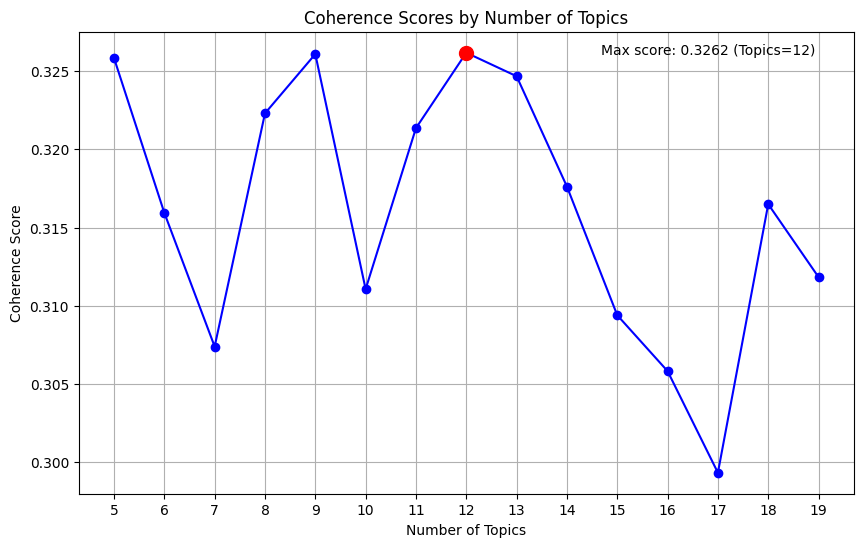

In [ ]:
def plot_coherence_scores(coherence_scores):
    """
    Plot coherence scores against the number of topics.
    
    Parameters:
    -----------
    coherence_scores : dict
        A dictionary with keys as the number of topics and values as the coherence score.
    """
    topics = list(coherence_scores.keys())
    scores = list(coherence_scores.values())

    # Identify the maximum coherence score
    max_topic = max(coherence_scores, key=coherence_scores.get)
    max_score = coherence_scores[max_topic]
    
    plt.figure(figsize=(10, 6))
    plt.plot(topics, scores, marker='o', linestyle='-', color='b')

    # Highlight the maximum score
    plt.scatter(max_topic, max_score, color='red', s=100, zorder=5, label='Maximum Coherence')
    plt.annotate(f'Max score: {max_score:.4f} (Topics={max_topic})',
                 xy=(max_topic, max_score),
                 xytext=(0.95, 0.95),
                 textcoords='axes fraction',
                 horizontalalignment='right')
    
    plt.title('Coherence Scores by Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(topics)
    plt.grid(True)
    plt.show()

# Plot the coherence scores
plot_coherence_scores(scores)

### LDA Topic Modeling

In [21]:
# 'data_bow' is already prepared from your code
lda = LatentDirichletAllocation(n_components=12, random_state=42)
data_document_topic_matrix = lda.fit_transform(data_bow)

# Get the feature names
feature_names = data_tokenizer_bow.get_feature_names_out()

# Inspect top words in each topic
n_top_words = 20
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")


Topic 0: percent, year, average, security, income, pay, social, social security, taxes, tax, america, last, per, make, national, almost, american, college, spending, wisconsin
Topic 1: years, rate, last, two, times, americans, four, unemployment, three, insurance, oil, five, health insurance, million, health, highest, since, half, higher, almost
Topic 2: state, cut, wisconsin, scott, gov, governor, education, rick, first, would, budget, gun, funding, tax, history, cost, actually, cuts, taxes, florida
Topic 3: one, new, texas, georgia, romney, state, mitt, support, american, mitt romney, made, sen, democrats, almost, republicans, system, country, law, three, job
Topic 4: billion, every, debt, congress, budget, day, administration, program, national, trillion, year, spending, bush, dollars, paid, spent, medicare, would, cuts, first
Topic 5: obama, president, barack, barack obama, president barack, obamas, president obama, president barack obama, said, bush, first, american, would, office

In [22]:
# Find the index of the topic with the highest probability for each document
dominant_topic_indices = np.argmax(data_document_topic_matrix, axis=1)

# Add this as a column to your original dataframe
data["dominant_topic"] = dominant_topic_indices

In [23]:
print(data["dominant_topic"].value_counts())
data["label"].value_counts()

dominant_topic
0     1870
9     1330
7     1240
2     1194
8     1145
3      954
11     935
4      883
1      847
5      831
10     812
6      795
Name: count, dtype: int64


label
1    2638
0    2511
2    2466
4    2108
3    2063
5    1050
Name: count, dtype: int64

In [24]:
data.groupby(["label", "dominant_topic"]).size().unstack(fill_value=0)

dominant_topic,0,1,2,3,4,5,6,7,8,9,10,11
label,,,,,,,,,,,,
0,382,145,243,168,157,187,133,271,253,240,151,181
1,377,175,273,200,180,158,162,231,226,288,163,205
2,365,192,261,183,196,107,183,213,150,284,174,158
3,319,184,167,208,150,91,143,197,145,211,141,107
4,291,108,170,132,148,146,129,219,244,208,128,185
5,136,43,80,63,52,142,45,109,127,99,55,99


In [25]:
pd.crosstab(data["dominant_topic"], data["label"], normalize="index")

label,0,1,2,3,4,5
dominant_topic,,,,,,
0,0.204278,0.201604,0.195187,0.170588,0.155615,0.072727
1,0.171192,0.206612,0.226682,0.217237,0.127509,0.050767
2,0.203518,0.228643,0.218593,0.139866,0.142379,0.067002
3,0.176101,0.209644,0.191824,0.218029,0.138365,0.066038
4,0.177803,0.203851,0.221971,0.169875,0.167610,0.058890
5,0.225030,0.190132,0.128761,0.109507,0.175692,0.170878
6,0.167296,0.203774,0.230189,0.179874,0.162264,0.056604
7,0.218548,0.186290,0.171774,0.158871,0.176613,0.087903
8,0.220961,0.197380,0.131004,0.126638,0.213100,0.110917


In [26]:
fake_labels = [0, 1, 4, 5]

data["fake"] = data["label"].apply(lambda x: "fake" if x in fake_labels else "true")

In [27]:
data["fake"].value_counts()

fake
fake    8307
true    4529
Name: count, dtype: int64

In [28]:
baseline_fake = (data["fake"] == "fake").mean()
print("Overall proportion of fake:", baseline_fake)

Overall proportion of fake: 0.6471642256154565


### Visualizations

In [29]:
pd.crosstab(data["dominant_topic"], data["fake"], normalize="index")

fake,fake,true
dominant_topic,,
0,0.634225,0.365775
1,0.556080,0.443920
2,0.641541,0.358459
3,0.590147,0.409853
4,0.608154,0.391846
5,0.761733,0.238267
6,0.589937,0.410063
7,0.669355,0.330645
8,0.742358,0.257642


In [30]:
ctab = pd.crosstab(data["dominant_topic"], data["fake"], normalize="index")
ctab["fake_diff"] = ctab["fake"] - baseline_fake
print(ctab)

fake                fake      true  fake_diff
dominant_topic                               
0               0.634225  0.365775  -0.012940
1               0.556080  0.443920  -0.091084
2               0.641541  0.358459  -0.005623
3               0.590147  0.409853  -0.057017
4               0.608154  0.391846  -0.039010
5               0.761733  0.238267   0.114569
6               0.589937  0.410063  -0.057227
7               0.669355  0.330645   0.022191
8               0.742358  0.257642   0.095194
9               0.627820  0.372180  -0.019345
10              0.612069  0.387931  -0.035095
11              0.716578  0.283422   0.069413


In [31]:
ctab = ctab.astype(float)  # ensure numeric
ctab_styled = (ctab.style
               .format("{:.2f}")  # correct format string
               )
ctab_styled


# Rename the axes
ctab = ctab.rename_axis("Topic", axis="index")          # Rename the row index name
ctab = ctab.rename_axis("News status", axis="columns")  # Rename the columns axis name

# Change the variable name
results_table = ctab

# Rename columns in results_table
results_table = results_table.rename(columns={
    "fake": "Fake Proportion",
    "true": "True Proportion",
    "fake_diff": "Difference from Baseline"
})

# Now `results_table` has nicer column names.
results_table


News status,Fake Proportion,True Proportion,Difference from Baseline
Topic,,,
0,0.634225,0.365775,-0.012940
1,0.556080,0.443920,-0.091084
2,0.641541,0.358459,-0.005623
3,0.590147,0.409853,-0.057017
4,0.608154,0.391846,-0.039010
5,0.761733,0.238267,0.114569
6,0.589937,0.410063,-0.057227
7,0.669355,0.330645,0.022191
8,0.742358,0.257642,0.095194


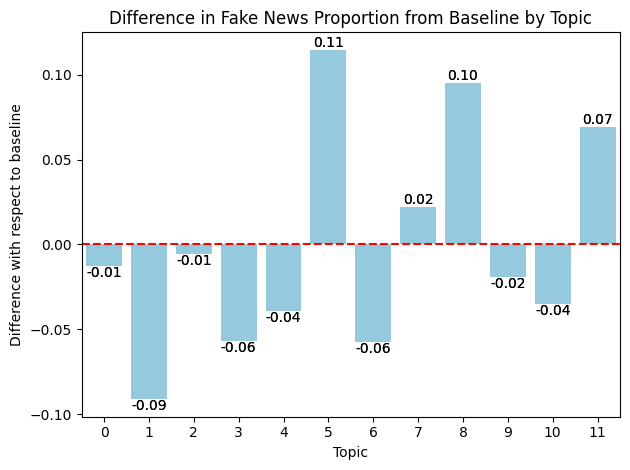

In [32]:
# Focus on the fake_diff column
ctab_reset = ctab.reset_index()  # reset index so 'dominant_topic' is a column
ax = sns.barplot(x="Topic", y="fake_diff", data=ctab_reset, color="skyblue")
sns.barplot(x="Topic", y="fake_diff", data=ctab_reset, color="skyblue")
plt.xlabel("Topic")
plt.ylabel("Difference with respect to baseline")
plt.title("Difference in Fake News Proportion from Baseline by Topic")
plt.axhline(y=0, color='red', linestyle='--')
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    # Determine vertical alignment and position based on sign of height
    if height >= 0:
        y_position = height # slightly above the bar
        va = 'bottom'
    else:
        y_position = height  # slightly below the bar
        va = 'top'
        
    # Place the text at the center of the bar
    ax.annotate(f"{height:.2f}", 
                (p.get_x() + p.get_width() / 2., y_position),
                ha='center', va=va, fontsize=10, color='black')

plt.show()


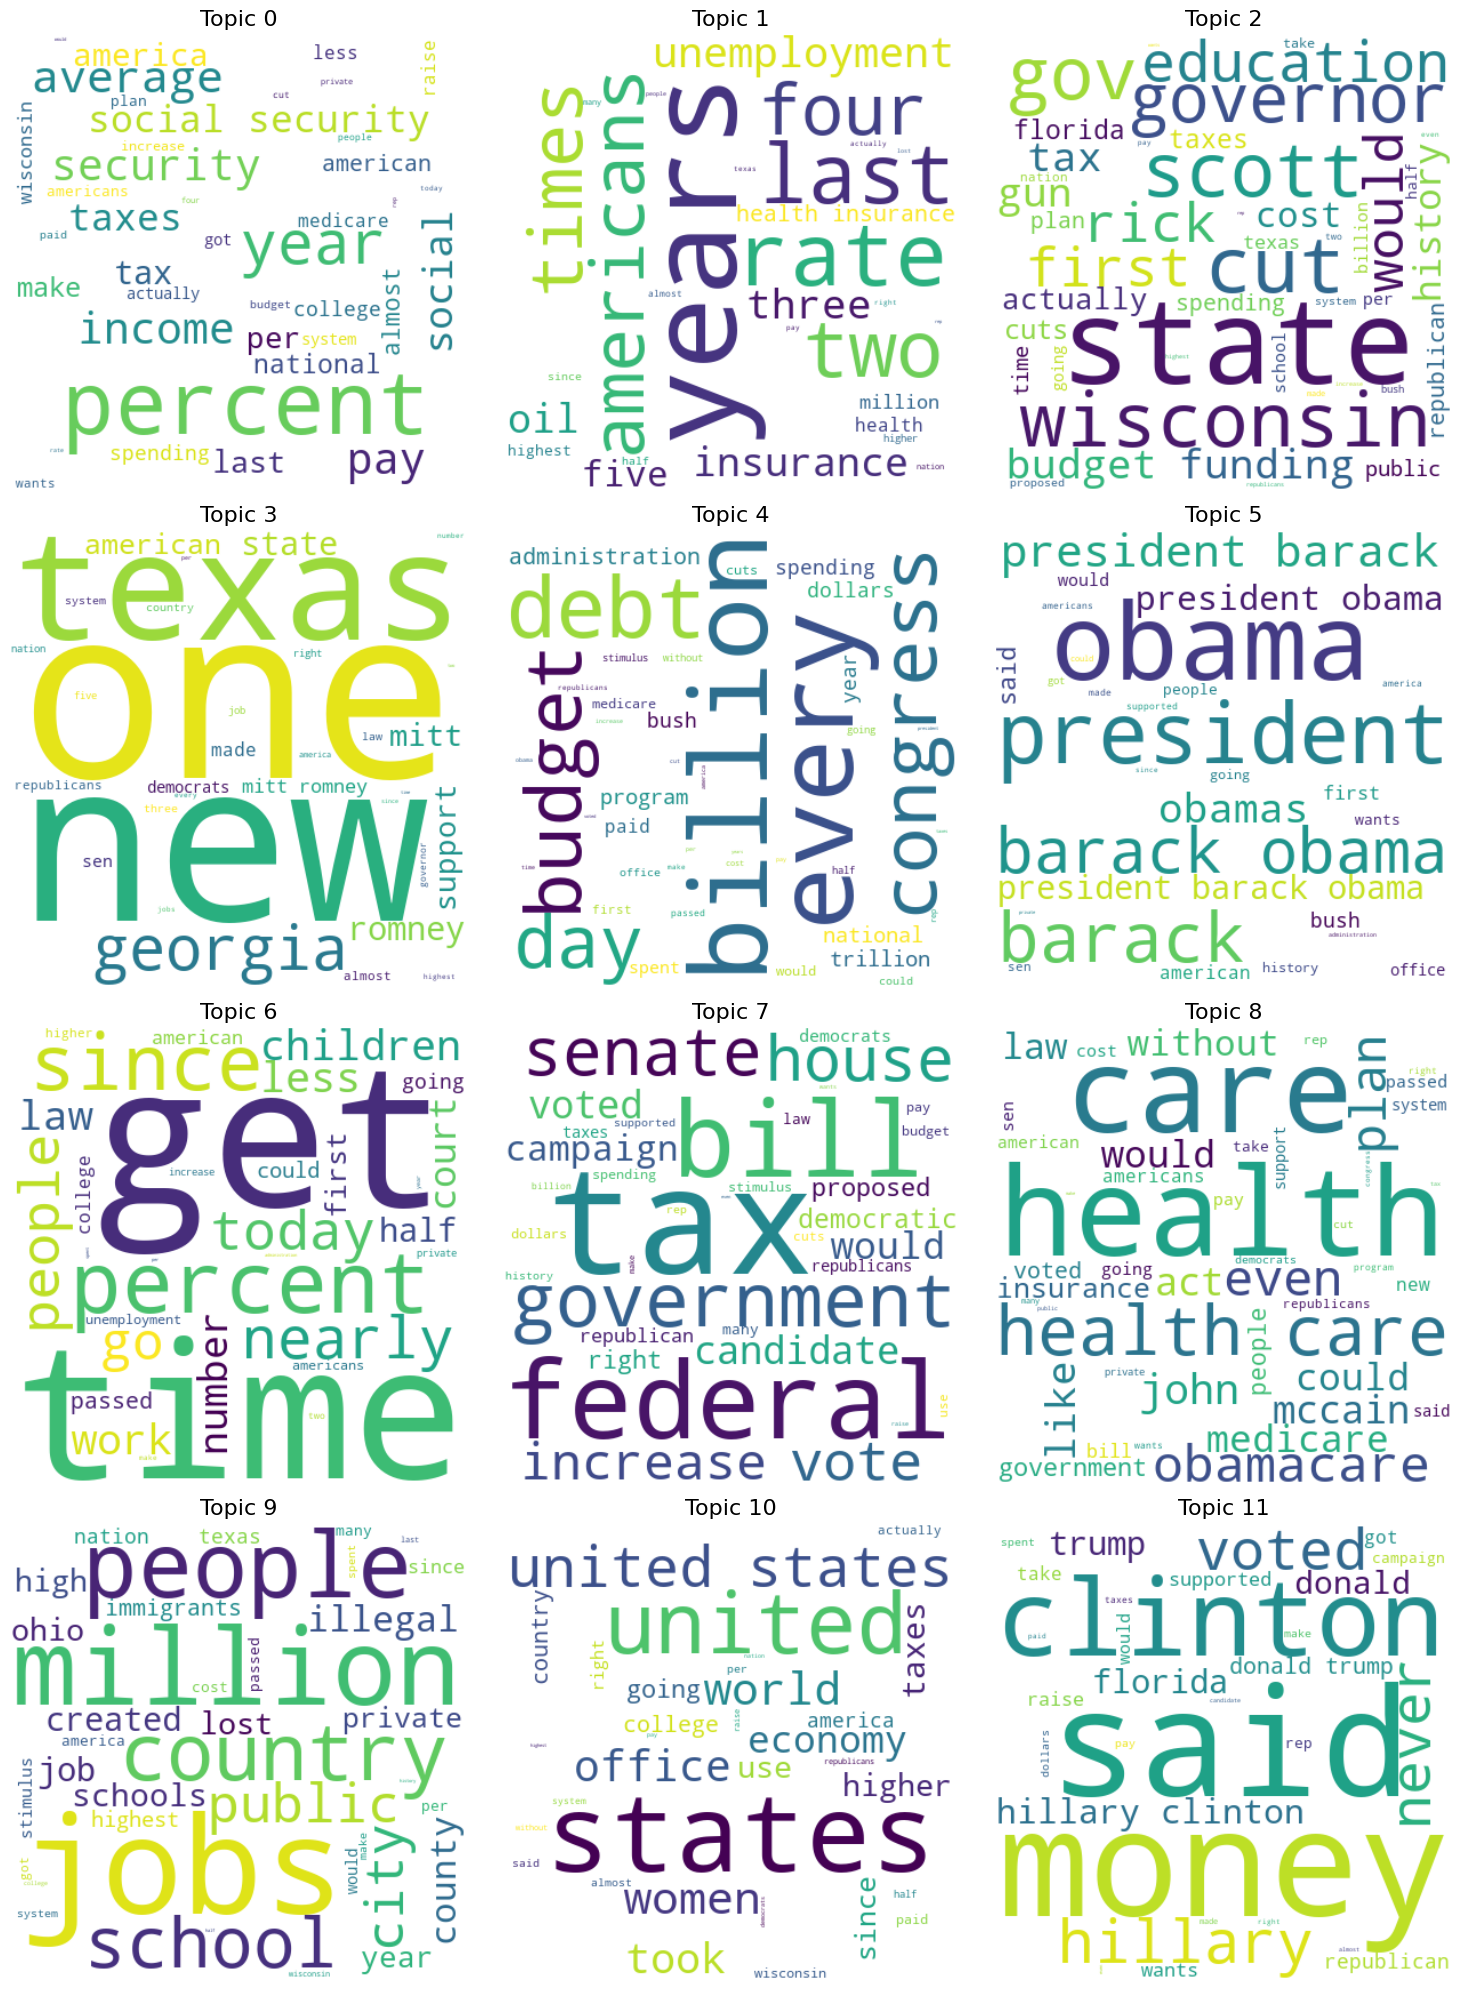

In [33]:
feature_names = data_tokenizer_bow.get_feature_names_out()
topic_word_matrix = lda.components_
topic_word_matrix = topic_word_matrix / topic_word_matrix.sum(axis=1, keepdims=True)

num_topics = lda.n_components
rows = 4
cols = math.ceil(num_topics / rows)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

# Generate all word clouds first
wcs = []
for i in range(num_topics):
    topic_word_probs = topic_word_matrix[i]
    word_freq = {feature_names[j]: topic_word_probs[j] for j in range(len(feature_names))}
    wc = WordCloud(background_color='white', width=400, height=400, max_words=100, colormap='viridis')
    wc.generate_from_frequencies(word_freq)
    wcs.append((i, wc))

# Check how many topics are in the last row
leftover = num_topics % cols

if leftover == 1:
    # There is exactly one topic in the last row
    # Place it in the center of that row instead of the leftmost cell
    center_idx = (rows - 1) * cols + (cols // 2)

    # Place all but the last topic normally
    for i, (t_i, wc) in enumerate(wcs[:-1]):
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].set_title(f"Topic {t_i}", fontsize=16)
        axes[i].axis('off')

    # Place the last topic in the center cell of the last row
    t_i, wc = wcs[-1]
    axes[center_idx].imshow(wc, interpolation='bilinear')
    axes[center_idx].set_title(f"Topic {t_i}", fontsize=16)
    axes[center_idx].axis('off')

    # Remove unused axes (all except the ones used)
    used_indices = list(range(num_topics - 1)) + [center_idx]
    for j, ax in enumerate(axes):
        if j not in used_indices:
            fig.delaxes(ax)
else:
    # If there's no single leftover or it doesn't matter, place topics normally
    for i, (t_i, wc) in enumerate(wcs):
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].set_title(f"Topic {t_i}", fontsize=16)
        axes[i].axis('off')

    # Remove any extra axes
    for j in range(num_topics, len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


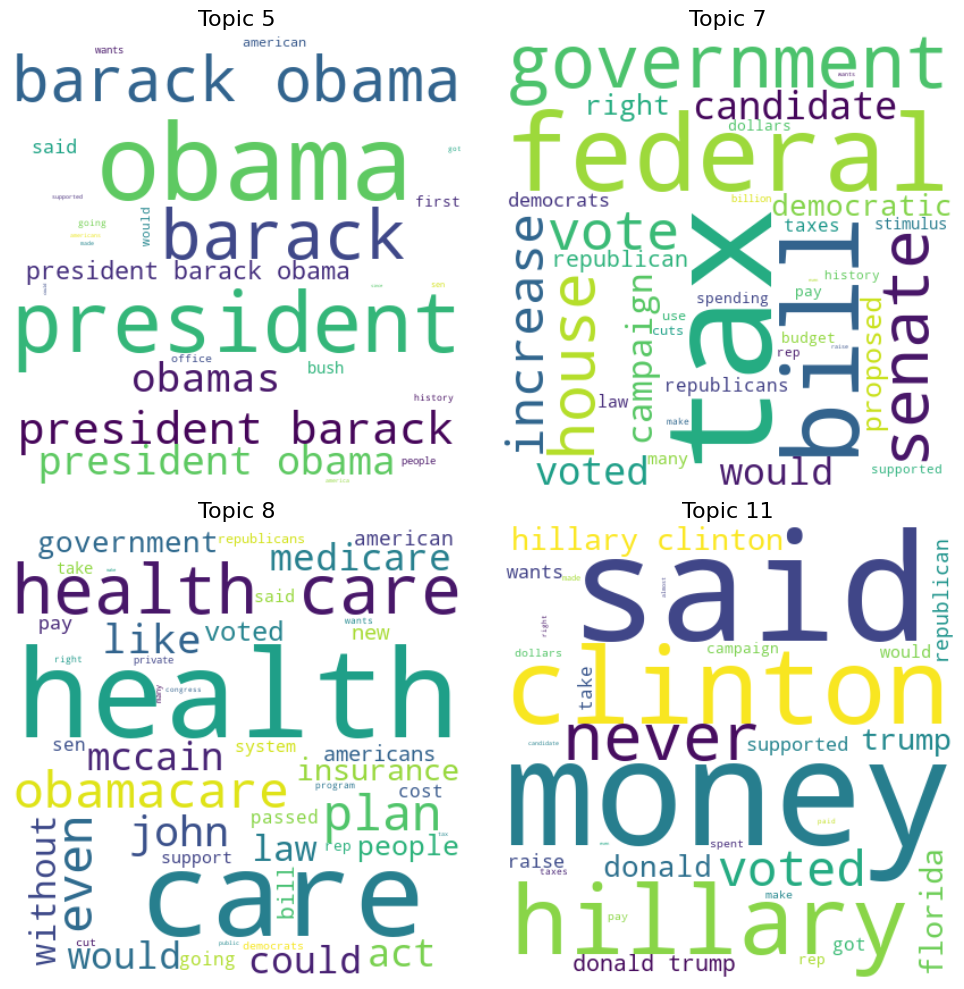

In [34]:
feature_names = data_tokenizer_bow.get_feature_names_out()
topic_word_matrix = lda.components_
topic_word_matrix = topic_word_matrix / topic_word_matrix.sum(axis=1, keepdims=True)

# Define which topics you want to visualize
topics_to_show = [5, 7, 8, 11]

# Create word clouds only for the chosen topics
wcs = []
for t_i in topics_to_show:
    topic_word_probs = topic_word_matrix[t_i]
    word_freq = {feature_names[j]: topic_word_probs[j] for j in range(len(feature_names))}
    wc = WordCloud(background_color='white', width=400, height=400, max_words=100, colormap='viridis')
    wc.generate_from_frequencies(word_freq)
    wcs.append((t_i, wc))

# Since you have 4 topics, let's arrange them in a 2x2 grid
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

for i, (t_i, wc) in enumerate(wcs):
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f"Topic {t_i}", fontsize=16)
    axes[i].axis('off')

# If there are any unused subplots, remove them
for j in range(len(wcs), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
